# Import Library

In [1]:
import numpy as np
import pandas as pd
from datetime import date, timedelta
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import skew, kurtosis

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers,Sequential,losses,optimizers,datasets

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
tf.config.list_physical_devices('GPU')

[]

# Data processing

In [2]:
import scipy.io as scio
import pandas as pd

#input
feature1 = r'\Training dataset\ACC_EW.mat'
data1 = scio.loadmat(feature1)
AA=data1['ACC_EW']
A=AA[:,0:300]

feature2 = r'\Training dataset\ACC_NS.mat'
data2 = scio.loadmat(feature2)
BB=data2['ACC_NS']
B=BB[:,0:300]

feature3 = r'\Training dataset\ACC_UD.mat'
data3 = scio.loadmat(feature3)
CC=data3['ACC_UD']
C=CC[:,0:300]


label = pd.read_csv(open(r'\Training dataset\lable.csv',encoding='UTF-8'))


In [3]:
raw_data1=np.hstack((A,B))
train_xx=np.hstack((raw_data1,C))

#print(train_xx.shape)


train_y=label.iloc[:,[3]].values  #知识嵌入
#y_data=label.iloc[:,[12]].values    #导入数据  iloc通过行号获取行数据
#print(train_y[0])
#print(train_y.shape)

In [4]:
train_x=[]
for i in range(len(train_xx)):
    train_x.append(np.array(train_xx[i].reshape(3,1,300)).T)

In [5]:
train_x=np.array(train_x)

In [6]:
#3#  ##Reshaping
train_x = np.reshape(train_x, (train_x.shape[0], 300, 3))
#print("0",train_x.shape[0])
#print("1",train_x.shape[1])
#print(train_x.shape)
#print(train_x)

# MagNet architecture, training and testing

In [7]:
seed=50
#50 17.20 1.32
drop_rate = 0.2
def get_model():

    inp1 = Input(shape=(300, 3), name='input_layer') 

    e = Conv1D(64, 3, padding = 'same')(inp1) 
    e = Dropout(drop_rate)(e, training=True)
    e = MaxPooling1D(4, padding='same')(e)
 
    e = Conv1D(32, 3, padding = 'same')(e) 
    e = Dropout(drop_rate)(e, training=True)
    e = MaxPooling1D(4, padding='same')(e)
#    e = Flatten()(e)
    
    e = Bidirectional(LSTM(100, return_sequences=False, dropout=0.0, recurrent_dropout=0.0))(e)

    e = Dense(1)(e)
    o = Activation('linear', name='output_layer')(e)
    

    #model = Model([inp_seq, inp_lap, inp_feat], out)  ,inpt2
    rms = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model = Model(inp1, o)
    model.compile(optimizer = rms, loss = 'mean_squared_error')

    return model

In [8]:
model = get_model()
model.summary() 

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 300, 3)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 300, 64)           640       
_________________________________________________________________
dropout (Dropout)            (None, 300, 64)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 75, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 75, 32)            6176      
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 32)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19, 32)           

In [9]:
### TRAIN A MODEL FOR EACH STORES USING ALL THE DATA AVAILALBE FROM OTHER STORES ###


tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(seed)
random.seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

pred_train_all=np.zeros(train_y.shape)
#pred_test_all = np.zeros(test_y.shape)
#pred_zhenli_all = np.zeros(y_zhenli.shape)

    
#es = EarlyStopping(patience=10, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)


In [10]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
lr_reducer = ReduceLROnPlateau(monitor="val_loss",
                               factor=0.1,
                                cooldown= 0,
                                patience= 5,
                                min_lr=0.1e-7)
early_stopping_monitor = EarlyStopping(monitor= 'val_loss', patience = 10) #10  17.20 1.32
callbacks = [lr_reducer, early_stopping_monitor]




model = get_model()
model.fit(train_x, train_y, epochs=300, batch_size=256,  
            validation_split=0.1, callbacks=callbacks)  #256 ,train_physics  ,test_physics ,train_physics

pred_train_all = model.predict(train_x).ravel()
#pred_test_all = model.predict(test_x).ravel()  ##ravel() 转换成1列


#pred_valid_all = scaler_seq.inverse_transform(pred_valid_all)
#reverse_valid = scaler_seq.inverse_transform(y_valid)
#pred_test_all = scaler_seq.inverse_transform(pred_test_all)
#reverse_test = scaler_seq.inverse_transform(y_test)

Epoch 1/300
162/162 [==============================] - 32s 199ms/step - loss: 1.2664 - val_loss: 0.6949
Epoch 2/300
162/162 [==============================] - 30s 183ms/step - loss: 0.4156 - val_loss: 0.3940
Epoch 3/300
162/162 [==============================] - 33s 205ms/step - loss: 0.3359 - val_loss: 0.3126
Epoch 4/300
162/162 [==============================] - 31s 189ms/step - loss: 0.3168 - val_loss: 0.3276
Epoch 5/300
162/162 [==============================] - 31s 190ms/step - loss: 0.2876 - val_loss: 0.3205
Epoch 6/300
162/162 [==============================] - 31s 192ms/step - loss: 0.2769 - val_loss: 0.2629
Epoch 7/300
162/162 [==============================] - 32s 198ms/step - loss: 0.2665 - val_loss: 0.2547
Epoch 8/300
162/162 [==============================] - 30s 188ms/step - loss: 0.2509 - val_loss: 0.2520
Epoch 9/300
162/162 [==============================] - 31s 191ms/step - loss: 0.2435 - val_loss: 0.2388
Epoch 10/300
162/162 [==============================] - 32s 195m

In [11]:
# 保存权重（推荐方式）
model.save_weights("MagNet_weights.h5")  # HDF5格式

In [12]:
def get_model_size_mb(model):
    params = model.count_params()
    # 假设所有参数为float32（4字节）
    size_mb = params * 4 / 1024**2
    return size_mb
 
print("Model size (MB):", get_model_size_mb(model))

Model size (MB): 0.4326515197753906


训练标准差STD= 0.3846838646322491
训练误差均值MEAN= -0.002012343118550268
训练平均绝对误差MAE= 0.28560303160906747
训练RMSE= 0.3846891280413696
训练MAPE= 6.5917989544642674
训练r2 score: 0.8555977681727569


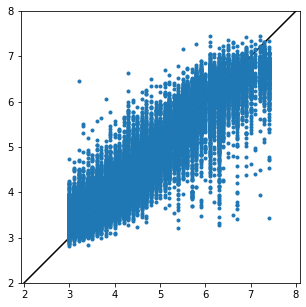

In [13]:
from sklearn import metrics
from sklearn.metrics import r2_score
print("训练标准差STD=",np.std(pred_train_all-train_y.ravel()))
print("训练误差均值MEAN=",np.mean(pred_train_all-train_y.ravel()))
print("训练平均绝对误差MAE=",metrics.mean_absolute_error(pred_train_all, train_y.ravel()))
print("训练RMSE=",metrics.mean_squared_error(pred_train_all, train_y.ravel())**0.5)
print("训练MAPE=",np.mean(np.abs((train_y.ravel() - pred_train_all) / train_y.ravel())) * 100)
print("训练r2 score:", r2_score(train_y.ravel(), pred_train_all))


plt.figure(figsize=(5, 5))
plt.axis('equal')

x3 = np.arange(2, 8, 0.01)
y3=x3
plt.plot(x3, y3, "black")
plt.plot(train_y.ravel(),pred_train_all,'.')
plt.xlim(2, 8)
plt.ylim(2, 8)
plt.show()

In [14]:
#########################保存训练结果####################################
pred_train_all=pred_train_all.reshape(pred_train_all.shape[0],1)

#y_score_tr=y_score_tr.reshape(y_score_tr.shape[0],1)
#print(pred_train_all.shape)
#print(train_y.shape)

tr_result=np.concatenate((train_y,pred_train_all),axis=1)

#print(tr_result.shape)

data_tr = pd.DataFrame(tr_result) #将数组转换为dataframe结构
data_tr.columns=['True M','Pred M']
writer_tr = pd.ExcelWriter(r'\MagNet\magtrain.xls')   # 写入Excel文件

data_tr.to_excel(writer_tr,float_format='%.5f',index=False)   ## ‘page_1’是写入excel的sheet名
writer_tr.save()
writer_tr.close()
#########################保存训练结果####################################

In [15]:
#震例
import scipy.io as scio
import pandas as pd

#input
feature1z = r'\Test dataset\ACC_EW.mat'
data1z = scio.loadmat(feature1z)
AAz=data1z['ACC_EW']
Az=AAz[:,0:300]

feature2z = r'\Test dataset\ACC_NS.mat'
data2z = scio.loadmat(feature2z)
BBz=data2z['ACC_NS']
Bz=BBz[:,0:300]

feature3z = r'\Test dataset\ACC_UD.mat'
data3z = scio.loadmat(feature3z)
CCz=data3z['ACC_UD']
Cz=CCz[:,0:300]



labelz = pd.read_csv(open(r'\Test dataset\lable.csv',encoding='UTF-8'))


In [16]:
raw_data1z=np.hstack((Az,Bz))
x_dataz=np.hstack((raw_data1z,Cz))


zhenli_y=labelz.iloc[:,[3]].values  #知识嵌入
#y_data=label.iloc[:,[12]].values    #导入数据  iloc通过行号获取行数据
#print(zhenli_y[0])
#print(zhenli_y.shape)

In [17]:
zhenli_x=[]
for i in range(len(x_dataz)):
    zhenli_x.append(np.array(x_dataz[i].reshape(3,1,300)).T)

In [18]:
zhenli_x=np.array(zhenli_x)

In [19]:
zhenli_x = np.reshape(zhenli_x, (zhenli_x.shape[0], 300, 3))

In [19]:
zhenli_x1=zhenli_x[0]
zhenli_x1=zhenli_x1.reshape(1, 300, 3)
print(zhenli_x1.shape)

(1, 300, 3)


In [20]:
import time
start_time = time.perf_counter()  # 记录开始时间
pred_zhenli_all = model.predict(zhenli_x1).ravel()  ##ravel() 转换成1列
end_time = time.perf_counter()  # 记录结束时间
elapsed_time_ms = (end_time - start_time) * 1000  # 转换为毫秒
print(f"Elapsed time: {elapsed_time_ms:.2f} ms")

Elapsed time: 30.20 ms


震例标准差STD= 0.39414631724476107
震例误差均值MEAN= -0.04707100350610378
震例平均绝对误差MAE= 0.2990884372587634
震例RMSE= 0.3969470981990919
震例MAPE= 6.951348402567086
震例r2 score: 0.8362033734050894


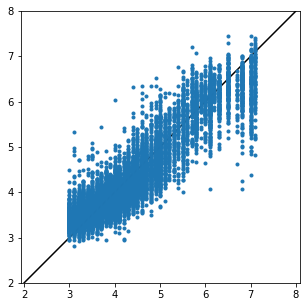

In [20]:
pred_zhenli_all = model.predict(zhenli_x).ravel()  ##ravel() 转换成1列
print("震例标准差STD=",np.std(pred_zhenli_all-zhenli_y.ravel()))
print("震例误差均值MEAN=",np.mean(pred_zhenli_all-zhenli_y.ravel()))
print("震例平均绝对误差MAE=",metrics.mean_absolute_error(pred_zhenli_all, zhenli_y.ravel()))
print("震例RMSE=",metrics.mean_squared_error(pred_zhenli_all, zhenli_y.ravel())**0.5)
print("震例MAPE=",np.mean(np.abs((zhenli_y.ravel() - pred_zhenli_all) / zhenli_y.ravel())) * 100)
print("震例r2 score:", r2_score(zhenli_y.ravel(), pred_zhenli_all))


plt.figure(figsize=(5, 5))
plt.axis('equal')

x3 = np.arange(2, 8, 0.01)
y3=x3
plt.plot(x3, y3, "black")
plt.plot(zhenli_y.ravel(),pred_zhenli_all,'.')
plt.xlim(2, 8)
plt.ylim(2, 8)
plt.show()  

In [21]:
#########################保存震例结果####################################
pred_zhenli_all=pred_zhenli_all.reshape(pred_zhenli_all.shape[0],1)

#print(pred_zhenli_all.shape)
#print(zhenli_y.shape)

tz_result=np.concatenate((zhenli_y,pred_zhenli_all),axis=1)

#print(tz_result.shape)

data_tz = pd.DataFrame(tz_result) #将数组转换为dataframe结构
data_tz.columns=['True M','Pred M']
writer_tz = pd.ExcelWriter(r'\MagNet\magtest.xls')   # 写入Excel文件

data_tz.to_excel(writer_tz,float_format='%.5f',index=False)   ## ‘page_1’是写入excel的sheet名
writer_tz.save()
writer_tz.close()
#########################保存震例结果####################################

# Test on the Chinese strong-ground motion data

In [22]:
#在中国地区的测试
import scipy.io as scio
import pandas as pd

#input
feature1z_CH = r'\Chinese strong-ground motion test dataset\ACC_EW.mat'
data1z_CH = scio.loadmat(feature1z_CH)
AAz_CH=data1z_CH['ACC_EW']
Az_CH=AAz_CH[:,0:300]

feature2z_CH = r'\Chinese strong-ground motion test dataset\ACC_NS.mat'
data2z_CH = scio.loadmat(feature2z_CH)
BBz_CH=data2z_CH['ACC_NS']
Bz_CH=BBz_CH[:,0:300]

feature3z_CH = r'\Chinese strong-ground motion test dataset\ACC_UD.mat'
data3z_CH = scio.loadmat(feature3z_CH)
CCz_CH=data3z_CH['ACC_UD']
Cz_CH=CCz_CH[:,0:300]



labelz_CH = pd.read_csv(open(r'\Chinese strong-ground motion test dataset\lable.csv',encoding='UTF-8'))


In [23]:
raw_data1z_CH=np.hstack((Az_CH,Bz_CH))
x_dataz_CH=np.hstack((raw_data1z_CH,Cz_CH))


zhenli_y_CH=labelz_CH.iloc[:,[3]].values  #知识嵌入
#y_data=label.iloc[:,[12]].values    #导入数据  iloc通过行号获取行数据
#print(zhenli_y_CH[0])
#print(zhenli_y_CH.shape)

In [24]:
zhenli_x_CH=[]
for i in range(len(x_dataz_CH)):
    zhenli_x_CH.append(np.array(x_dataz_CH[i].reshape(3,1,300)).T)

In [25]:
zhenli_x_CH=np.array(zhenli_x_CH)

In [26]:
zhenli_x_CH = np.reshape(zhenli_x_CH, (zhenli_x_CH.shape[0], 300, 3))

震例标准差STD= 0.48225163134146226
震例误差均值MEAN= 0.2659895101144842
震例平均绝对误差MAE= 0.42329044544486577
震例RMSE= 0.5507422767705825
震例MAPE= 9.830528748621735
震例r2 score: 0.5263166716537793


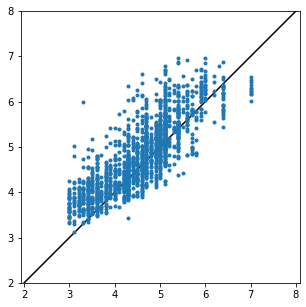

In [27]:
pred_zhenli_all_CH = model.predict(zhenli_x_CH).ravel()  ##ravel() 转换成1列
print("震例标准差STD=",np.std(pred_zhenli_all_CH-zhenli_y_CH.ravel()))
print("震例误差均值MEAN=",np.mean(pred_zhenli_all_CH-zhenli_y_CH.ravel()))
print("震例平均绝对误差MAE=",metrics.mean_absolute_error(pred_zhenli_all_CH, zhenli_y_CH.ravel()))
print("震例RMSE=",metrics.mean_squared_error(pred_zhenli_all_CH, zhenli_y_CH.ravel())**0.5)
print("震例MAPE=",np.mean(np.abs((zhenli_y_CH.ravel() - pred_zhenli_all_CH) / zhenli_y_CH.ravel())) * 100)
print("震例r2 score:", r2_score(zhenli_y_CH.ravel(), pred_zhenli_all_CH))


plt.figure(figsize=(5, 5))
plt.axis('equal')

x3 = np.arange(2, 8, 0.01)
y3=x3
plt.plot(x3, y3, "black")
plt.plot(zhenli_y_CH.ravel(),pred_zhenli_all_CH,'.')
plt.xlim(2, 8)
plt.ylim(2, 8)
plt.show()  